# LPFP algorithm for MFGs with optimal stopping

## By Roxana Dumitrescu, Marcos Leutscher and Peter Tankov

See https://arxiv.org/abs/2202.11428

In this notebook we develop the *linear programming fictitious play algorithm* for MFGs of optimal stopping (and absorption). 

The MFG problem for optimal stopping will be the following: 

i) Fix a flow of subprobability measures $m=(m_t)_{t\in [0, T]}$ on $\bar{\mathcal{O}}$ and a probability measure $\mu$ on $[0, T]\times\bar{\mathcal{O}}$, and find the solution to the optimal stopping problem
\begin{equation}
\begin{aligned}
\sup_{\tau} & \quad \mathbb{E}\left[\int_{0}^{\tau\wedge \tau_\mathcal{O}^{X^{m}}} f\left(t, X^{m}_t, m_t\right) dt + g\left(\tau\wedge \tau_\mathcal{O}^{X^{m}}, X^{m}_{\tau\wedge \tau_\mathcal{O}^{X^{m}}}, \mu\right)\right],\\
\text{s.t. } & \quad dX_{t}^{m}=b\left(t, X_{t}^{m}, m_t\right) dt+\sigma\left(t, X_{t}^{m}, m_t\right) dW_{t},\\
& \quad X_0^{m}\sim m_0^*,
\end{aligned}
\end{equation}
where $\tau_\mathcal{O}^{X^{m}}=inf\{t\geq 0: X_t^{m}\notin \mathcal{O}\}$.

ii) Given a solution $\tau^{m, \mu}$ of the above problem for the agent facing a mean-field $(m, \mu)$, find $m$ such that $m_t=\mathbb P\left(X^{m}_t\in \cdot, t<\tau^{m, \mu}\wedge \tau_\mathcal{O}^{X^{m}}\right)$ for all $t\in [0, T]$ and $\mu$ such that $\mu =\mathcal{L}\left(\tau^{m, \mu}\wedge \tau_\mathcal{O}^{X^{m}}, X_{\tau^{m, \mu}\wedge \tau_\mathcal{O}^{X^{m}}}^m\right)$.


The inputs for the algorithm consist in the following data:

- An initial distribution of the players $m_0^*\in \mathcal P(\mathcal{O})$.
- A terminal horizon $T>0$.
- Functions $b$, $\sigma$, $f$ and $g$.
- Initial guess for the mean field $(\bar\mu^{(0)}, \bar m^{(0)})$.
- Discretrization sets for $[0, T]$ and $\bar{\mathcal{O}}$.

At iteration $k$, the algorithm computes the best response $(\hat\mu^{(k+1)}, \hat m^{(k+1)})$ for a fixed distribution of the players $(\bar\mu^{(k)}, \bar m^{(k)})$ which influences the dynamics and the rewards. This step can be seen as a single-agent problem in the sense that for fixed $(\bar\mu^{(k)}, \bar m^{(k)})$, one solves a classical optimal stopping problem. Therefore, we use linear programming to compute the best response. 

Once the best response is calculated, we update our guess for the mean-field as it is suggested in the fictitious play framework:
$$(\bar \mu^{(k+1)}, \bar m^{(k+1)}):=\frac{k}{k+1}(\bar \mu^{(k)}, \bar m^{(k)}) + \frac{1}{k+1}(\hat\mu^{(k+1)}, \hat m^{(k+1)}).$$

We import the following packages

In [2]:
# Package imports
import numpy as np
import scipy
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from scipy.stats import norm
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from scipy.sparse import hstack

## 1) Best response

We start with the best response algorithm via linear programming.

### Discretization of the time space

We discretize the time space by 
$$t_i=\frac{iT}{n_t}, \quad i\in \{0, 1, \ldots n_t\},$$
where $n_t\in \mathbb N^*$. We denote $\Delta =T/n_t$. 

### Discretization of the state space

We assume that $\mathcal{O}=(\underline x, \overline x)$. We discretize the state space with $n_s+1$ points $\underline x = x_0< x_1< \ldots < x_{n_s} = \overline x$, where $n_s\in \mathbb N^*$. We denote
$$\delta_j=x_{j}-x_{j-1}, \quad j\in \{1, \ldots, n_s\}.$$

We suppose that the points are equally separated with separation $\delta$.

### Discretization of the initial distribution

The initial state distribution $m_0^*$ is approximated by convex combinations of dirac masses on the discretization of $\mathcal{O}$. The discretized initial state distribution will be denoted in the code by m0 and it will be a vector of $n_s+1$ components indicating the mass for each $x_j$, $j\in\{0, \ldots, x_{n_s}\}$, but since $m_0^*$ is supported in $\mathcal{O}$, we set the first and last components to $0$.

### Drift, volatility and reward functions

We are given functions $(t, x)\mapsto (b, \sigma, f, g)(t, x)$. Note that the mean-field term does not appear on the functions since we are treating it as fixed for the best response computation.

### Discretized Generator and test functions

We define
$$Lu(t, x)=\frac{\partial u}{\partial t}(t, x) + b(t, x)\frac{\partial u}{\partial x}(t, x) + \frac{\sigma^2}{2}(t, x)\frac{\partial^2 u}{\partial x^2}(t, x), \quad \forall u\in \mathcal{D}(L):=C^{1, 2}_b([0, T]\times \bar{\mathcal{O}}).$$

We set $\mathcal{D}(\hat L)$ as the functions in $\mathcal{D}(L)=C^{1, 2}_b([0, T]\times \bar{\mathcal{O}})$ restricted to the discretization Time-State. 

We discretize the derivatives for $u\in \mathcal{D}(\hat L)$ as follows: for $i\in\{0, 1, \ldots, n_t-1\}$ and $j\in\{1, \ldots, n_s-1\}$,
$$\hat L_t u (t_i, x_j)= \frac{1}{\Delta}[u(t_{i+1}, x_j)-u(t_i, x_j)],$$
$$\hat L_x^u u (t_i, x_j)=\frac{1}{\delta}\max(b(t_i, x_j), 0)[u(t_{i+1}, x_{j+1})-u(t_{i+1}, x_{j})],$$
$$\hat L_x^d u (t_i, x_j)=\frac{1}{\delta}\min(b(t_i, x_j), 0)[u(t_{i+1}, x_{j})-u(t_{i+1}, x_{j-1})],$$
$$\hat L_{xx} u (t_i, x_j)=\frac{1}{\delta^2}\frac{\sigma^2}{2}(t_i, x_j)[u(t_{i+1}, x_{j+1}) + u(t_{i+1}, x_{j-1})-2u(t_{i+1}, x_j)].$$
The discretized generator has the form:
$$\hat L u (t_i, x_j) = \hat L_t u (t_i, x_j) + \hat L_x^u u (t_i, x_j) + \hat L_x^d u (t_i, x_j) + \hat L_{xx} u (t_i, x_j).$$

The constraint reads as
$$
\sum_{i=0}^{n_t}\sum_{j=0}^{n_s} u(t_i, x_j)\hat\mu(t_i, x_j) - \Delta\sum_{i=0}^{n_t-1}\sum_{j=1}^{n_s-1} \hat L u(t_i, x_j) \hat m(t_i, x_j) = \sum_{j=0}^{n_s}u(t_0, x_j) m_0(x_j), \tag{1}
$$
for $u\in \mathcal{D}(\hat L)$.

The set $\mathcal{D}(\hat L)$ is equal to the linear span of the indicators functions 
$$\mathbf{1}_{\{(t_i, x_j)\}}, \quad i\in\{0, 1, \ldots, n_t\}, \; j\in\{0, 1, \ldots, n_s\}$$ 
on the Time-State grid. By linearity, it suffices to evaluate the constraint on the set of indicator functions.

Stacking all the indicator functions evaluated in the Time-State grid by rows we get the following matrix:

$$U=
\begin{bmatrix}
u_{1}(t_0, x_0) & \ldots & u_{1}(t_0, x_{n_s}) & \ldots & u_1(t_{n_t}, x_{n_s})\\
\vdots & & & & \vdots\\
u_{n_f}(t_0, x_0) & \ldots & u_{n_f}(t_0, x_{n_s}) & \ldots & u_{n_f}(t_{n_t}, x_{n_s})
\end{bmatrix},
$$
where $n_f$ is the total number of indicator functions. In particular we stack the functions in such a way that $U$ is equal to the indentity matrix. This matrix will be used to define the constraints.

We write the constraint (1) in the following form
$$A_{eq} z = b_{eq},$$
where $A_{eq}$ is a matrix and $z$ and $b_{eq}$ are vectors.

In our case, we will set $z=(z_{mu}, z_m)^T$
$$z_{mu}=[\hat\mu(t_0, x_0), \ldots, \hat\mu(t_0, x_{n_s}), \hat\mu(t_1, x_{0}), \ldots, \hat\mu(t_1, x_{n_s}), \ldots,\hat\mu(t_{n_t}, x_{0}), \ldots, \hat\mu(t_{n_t}, x_{n_s})],$$
$$z_m = [\hat m(t_0, x_1), \ldots, \hat m(t_0, x_{n_s-1}), \hat m(t_1, x_1), \ldots, \hat m(t_1, x_{n_s-1}), \ldots, \hat m(t_{n_t-1}, x_{1}), \ldots, \hat m(t_{n_t-1}, x_{n_s-1})].$$
We also set $A_{eq}=[A_{eq}^{mu}, A_{eq}^m]$, where
$$A_{eq}^{mu}=
\begin{bmatrix}
u_{1}(t_0, x_0) & \ldots & u_{1}(t_0, x_{n_s}) & \ldots & u_1(t_{n_t}, x_{n_s})\\
\vdots & & & & \vdots\\
u_{n_f}(t_0, x_0) & \ldots & u_{n_f}(t_0, x_{n_s}) & \ldots & u_{n_f}(t_{n_t}, x_{n_s})
\end{bmatrix}
=U,
$$
$$A_{eq}^{m}= -\Delta\times
\begin{bmatrix}
\hat L u_{1}(t_0, x_1) & \ldots & \hat L u_{1}(t_0, x_{n_s-1}) & \ldots & \hat L u_{1}(t_{n_t-1}, x_{n_s-1})\\
\vdots & & & & \vdots\\
\hat L u_{n_f}(t_0, x_1) & \ldots & \hat L u_{n_f}(t_0, x_{n_s-1}) & \ldots & \hat L u_{n_f}(t_{n_t-1}, x_{n_s-1})
\end{bmatrix}.
$$
We define 
$$b_{eq}=[u_1(t_0, \cdot)^Tm_0, \ldots, u_{n_f}(t_0, \cdot)^T m_0]^T$$

### Reward

The reward is given by
$$
\sum_{i=0}^{n_t}\sum_{j=0}^{n_s} g(t_i, x_j)\hat\mu(t_i, x_j) + \Delta\times \sum_{i=0}^{n_t-1}\sum_{j=1}^{n_s-1} f(t_i, x_j) \hat m(t_i, x_j).
$$

We will minimize the function $c^Tz$ subject to the constraint $A_{eq} z = b_{eq}$, where $c$ is a vector of costs. We will set $c=-(r_{mu}, r_m)^T$, where
$$r_{mu}=[g(t_0, x_0), \ldots, g(t_0, x_{n_s}), g(t_1, x_{0}), \ldots, g(t_1, x_{n_s}), \ldots, g(t_{n_t}, x_{0}), \ldots, g(t_{n_t}, x_{n_s})],$$
$$r_m = \Delta \times [f(t_0, x_1), \ldots, f(t_0, x_{n_s-1}), f(t_1, x_1), \ldots, f(t_1, x_{n_s-1}), \ldots, f(t_{n_t-1}, x_{n_s-1})].$$

In [3]:
def constraint_generator(Time, State, b, s, Delta, delta, m0, U, Time_mesh_mu, State_mesh_mu, Time_mesh_m, State_mesh_m):
    """
    Argument:
    Time -- time grid
    State -- state grid
    b -- drift function, it is a function with arguments (t,x) of type numpy array, and returning a numpy array   
    s -- volatility function, with same definition as b
    Delta -- time step
    delta -- state step
    m0 -- array for the initial distribution on State
    U -- matrix of test functions valued on the grid
    Time_mesh_mu -- Time in a time-state mesh for mu
    State_mesh_mu -- State in a time-state mesh for mu
    Time_mesh_m -- Time in a time-state mesh for m
    State_mesh_m -- State in a time-state mesh for m
    
    Returns:
    A_eq -- matrix constraint
    b_eq -- column vector constraint
    """
    
    d_t = Time.shape[0]
    d_s = State.shape[0]
    d_f = U.shape[0]
    
    B = b(Time_mesh_m, State_mesh_m)
    S = s(Time_mesh_m, State_mesh_m)
    
    C1 = 1/delta * np.maximum(B, 0)
    C2 = 1/delta * np.minimum(B, 0)
    C3 = 1/(delta**2) * S**2/2
    
    # mu matrix
    A_eq_mu = U
    
    A_eq_m = lil_matrix((d_f, (d_t-1) * (d_s-2))) 
    b_eq = np.zeros((d_f, 1))
    
    for counter in range(d_f):
        # m matrix
        V = U[counter, :].reshape((d_t, d_s))
        L_t = 1/Delta * (V[1:,1:-1]-V[:-1,1:-1])
        L_x_u = C1 * (V[1:, 2:] - V[1:, 1:-1])
        L_x_d = C2 * (V[1:, 1:-1] - V[1:, :-2])
        L_xx = C3 * (V[1:, 2:] + V[1:, :-2] - 2 * V[1:, 1:-1])
        L = L_t + L_x_u + L_x_d + L_xx
        A_eq_m[counter, :] = - Delta*L.reshape(1,-1)
        # b_eq
        b_eq[counter, 0] = np.dot(V[0, :].T, m0)

    A_eq_mu = csr_matrix(A_eq_mu)
    A_eq_m = csr_matrix(A_eq_m)
        
    A_eq = hstack((A_eq_mu, A_eq_m))
    A_eq = csr_matrix(A_eq)
    
    return A_eq, b_eq

In [4]:
def cost_generator(Delta, f, g, Time_mesh_mu, State_mesh_mu, Time_mesh_m, State_mesh_m):
    """
    Argument:
    Delta -- time step
    f -- instantaneous reward function, it is a function with arguments (t,x) of type numpy array, and returning a numpy array
    g -- terminal reward function, with same definition as f
    Time_mesh_mu -- Time in a time-state mesh for mu
    State_mesh_mu -- State in a time-state mesh for mu
    Time_mesh_m -- Time in a time-state mesh for m
    State_mesh_m -- State in a time-state mesh for m
    
    Returns:
    c -- cost vector
    """

    G = g(Time_mesh_mu, State_mesh_mu)
    r_mu = G.reshape(1,-1) 
                 
    F = f(Time_mesh_m, State_mesh_m)
    r_m = Delta * F.reshape(1,-1)

    
    ## Attention with the minus sign, since the linear program is for costs instead of rewards                   
    c = - np.concatenate((r_mu.T, r_m.T), axis=0)
    
    return c

### Interior point algorithm

We give two different ways to solve the LP problem with python. The first one is based on scipy's linprog function and the second one uses Gurobi's LP solver (a free academic license is available).

In [5]:
# Scipy linprog

def best_response(Time, State, A_eq, b_eq, c):
    """
    Argument: 
    Time -- time grid
    State -- state grid
    A_eq -- matrix constraint
    b_eq -- column vector constraint
    c -- cost vector
    
    Returns:
    value -- maximal value
    mu_sol -- 2-array with mu valued in the grid Time-State
    m_sol -- 2-array with m valued in the grid Time-State
    """
    
    d_t = Time.shape[0]
    d_s = State.shape[0]

    res = linprog(c, A_eq = A_eq, b_eq = b_eq, method ='interior-point',
                  options = {"sparse": True, 'rr':False, 'permc_spec':'COLAMD'})
                
    z = res.x
    
    z_mu = z[:(d_t*d_s)]
    z_m = z[(d_t*d_s):]
    
    mu_sol = z_mu.reshape((d_t, d_s))
    m_sol = z_m.reshape((d_t-1, d_s-2))
    
    value = - res.fun 
    
    return value, mu_sol, m_sol

In order to accelarate the computations, one can use the Gurobi solver. In that case do not use the previous function "best_response", but the following one. 

In [6]:
import gurobipy as gp
from gurobipy import GRB

In [7]:
# Gurobi

def best_response(Time, State, A_eq, b_eq, c):
    """
    Argument: 
    Time -- time grid
    State -- state grid
    A_eq -- matrix constraint
    b_eq -- column vector constraint
    c -- cost vector
    
    Returns:
    value -- maximal value
    mu_sol -- 2-array with mu valued in the grid Time-State
    m_sol -- 2-array with m valued in the grid Time-State
    """
    
    #A_eq = csr_matrix(A_eq)
    
    reward = -c
    
    model = gp.Model()
    model.Params.LogToConsole = 0
    rows, cols = len(b_eq), len(reward)
    variables = []
    for j in range(cols):
        variables.append(model.addVar(lb=0, ub=1, obj=reward[j, 0]))
    model.update()
    
    # iterate over the rows of A_eq adding each row into the model
    for i in range(rows):
        start = A_eq.indptr[i]
        end = A_eq.indptr[i+1]
        variables_row = [variables[j] for j in A_eq.indices[start:end]]
        coeff = A_eq.data[start:end]
        expr = gp.LinExpr(coeff, variables_row)
        model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=b_eq[i, 0])
    
    model.update()
    model.ModelSense = -1
    model.optimize()
    
    d_t = Time.shape[0]
    d_s = State.shape[0]
    
    z = [variables[j].X for j in range(cols)]
    
    z_mu = np.array(z[:(d_t*d_s)])
    z_m = np.array(z[(d_t*d_s):])
    
    mu_sol = z_mu.reshape((d_t, d_s))
    m_sol = z_m.reshape((d_t-1, d_s-2))
                        
    return model.ObjVal, mu_sol, m_sol

## 2) Fictitious Play iteration

Here we present the Fictitious Play iteration of the best responses approximating the LP MFG Nash equilibrium. If the coefficients $b$ and $\sigma$ do not depend on the measure, the matrix of the constraint is computed only once. Moreover, we give two possibilities to track the convergence of the algorithm. The first one is the exploitability (which can be used when $b$ and $\sigma$ do not depend on the measure):
$$\varepsilon(\bar\mu, \bar m):=\sup_{(\mu, m)}\langle m-\bar m, f[\bar m]\rangle + \langle \mu-\bar \mu, g[\bar \mu]\rangle,$$
where the supremum is taken over the measures satisfying the constraint. The second one is a distance between the measures:
$$d((\mu, m),(\bar\mu, \bar m)):=\max\left\{\Delta \sum_{i, j}|m(t_i, x_j) - \bar m(t_i, x_j)|, \sum_{i, j}|\mu(t_i, x_j) - \bar \mu(t_i, x_j)|\right\}.$$

In [8]:
def fictitious_play(Time, State, b_factory, s_factory, Delta, delta,
                    m0, f_factory, g_factory, tol, N_iter, mu_tilde_0, m_tilde_0, coeff_dep, error):
    """
    Argument:
    Time -- time grid
    State -- state grid
    b_factory -- mean field functional for b  
    s_factory -- mean field functional for sigma 
    Delta -- time step
    delta -- state step
    m0 -- array for the initial distribution on State
    f_factory -- mean field functional for f
    g_factory -- mean field functional for g  
    tol -- error tolerance
    N_iter -- maximum number of iterations
    mu_tilde_0 -- preliminary guess for mu
    m_tilde_0 -- preliminary guess for m
    coeff_dep -- True if the coefficients b or sigma depend on the measure, False if they do not
    error -- string. Choose between 'exploitability' and 'dist'. When the coefficients b or sigma depend on the measure
             use 'dist'
    
    Returns:
    value -- approximate Nash value
    mu_bar -- 2-array with mu valued in the grid Time-State
    m_bar -- 2-array with m valued in the grid Time-State
    mu_hat -- 2-array with mu valued in the grid Time-State
    m_hat -- 2-array with m valued in the grid Time-State
    eps_array -- 1-array with the errors
    """
    
    U = np.identity((Time.shape[0] * State.shape[0]))
    
    # Mesh grids: we will use the following meshgrids for mu and m

    Time_mesh_mu, State_mesh_mu = np.meshgrid(Time[:, 0], State[:, 0], indexing='ij') 
    Time_mesh_m, State_mesh_m = np.meshgrid(Time[:-1, 0], State[1:-1, 0], indexing='ij') 
    
    # The preliminary guess mu_tilde_0, m_tilde_0 does not satisfy necessarily the constraint, henceforth we get the initial
    # guess by computing the best response to the preliminary guess
    
    m_bar = m_tilde_0
    mu_bar = mu_tilde_0
    
    # The functions b_factory, s_factory, etc are defined later
    
    b_n = b_factory(m_bar, State[1:-1, 0])
    s_n = s_factory(m_bar, State[1:-1, 0])
    f_n = f_factory(m_bar, State[1:-1, 0])
    g_n = g_factory(mu_bar, Time_mesh_mu, State_mesh_mu)
    
    A_eq, b_eq = constraint_generator(Time, State, b_n, s_n, Delta, delta, m0, U, 
                                      Time_mesh_mu, State_mesh_mu, Time_mesh_m, State_mesh_m)
    
    c = cost_generator(Delta, f_n, g_n, Time_mesh_mu, State_mesh_mu, Time_mesh_m, State_mesh_m)
    
    value, mu_hat, m_hat = best_response(Time, State, A_eq, b_eq, c)
        
    m_bar = m_hat
    mu_bar = mu_hat
    
    n = 1
    
    eps = tol + 1 
    
    eps_list = []
    
    message = "Iteration: {:4d}; Error:  {:.6f}"
    
    while (eps > tol) and (n <= N_iter):
        
        if coeff_dep == True:
            
            b_n = b_factory(m_bar, State[1:-1, 0])
            s_n = s_factory(m_bar, State[1:-1, 0])
            A_eq, b_eq = constraint_generator(Time, State, b_n, s_n, Delta, delta, m0, U, 
                                              Time_mesh_mu, State_mesh_mu, Time_mesh_m, State_mesh_m)
            
        f_n = f_factory(m_bar, State[1:-1, 0])
        g_n = g_factory(mu_bar, Time_mesh_mu, State_mesh_mu)
    
        c = cost_generator(Delta, f_n, g_n, Time_mesh_mu, State_mesh_mu, Time_mesh_m, State_mesh_m)
        
        value, mu_hat, m_hat = best_response(Time, State, A_eq, b_eq, c)
        
        # Error
        if error == 'exploitability':
            
            eps = Delta*np.sum(f_n(Time_mesh_m, State_mesh_m) * (m_hat - m_bar)) + \
                  np.sum(g_n(Time_mesh_mu, State_mesh_mu) * (mu_hat - mu_bar))
        else:
            
            eps = np.maximum(Delta*np.sum(np.abs(m_hat - m_bar)), np.sum(np.abs(mu_hat - mu_bar)))
        
        
        eps_list.append(eps)
        
        mu_bar = n/(n+1)*mu_bar + 1/(n+1)*mu_hat
        m_bar = n/(n+1)*m_bar + 1/(n+1)*m_hat
        
        print(message.format(n, eps))
        
        n += 1

    eps_array = np.array(eps_list)
        
    return value, mu_bar, m_bar, mu_hat, m_hat, eps_array

## 3) Example

We give an example of MFG of optimal stopping and approximate the equilibrium via the LPFP algorithm.

We define the Time space, State space and the intial distribution of the players. The numbers $\delta$ and $\Delta$ should satisfy:
$$\Delta\leq \frac{\delta^2}{\sigma^2(t_i, x_j) + \delta |b|(t_i, x_j)}, \quad \forall (i, j).$$

In [9]:
#Initial data
T = 1.0

n_t = 40
n_s = 40

n_t = 200 
n_s = 200


# Time space
Time = np.linspace(0, T, num = n_t + 1)
Time = np.reshape(Time, (Time.shape[0], 1))

Delta = Time[1, 0] - Time[0, 0]

# State space
State = np.linspace(-7.5, 7.5, num = n_s + 1)
State = np.reshape(State, (State.shape[0], 1))

delta = State[1, 0] - State[0, 0]

# Initial distribution
norm_0 = norm.pdf(State[1:-1, 0], np.mean(State), 4**(1/2))
norm_0 = np.insert(norm_0, 0, 0.)
norm_0 = np.insert(norm_0, len(norm_0), 0.)
m0 = np.reshape(norm_0, (norm_0.shape[0], 1))
m0 = m0/np.sum(m0)

# Mesh grids: we will use the following meshgrids for mu and m

Time_mesh_mu, State_mesh_mu = np.meshgrid(Time[:, 0], State[:, 0], indexing='ij') 
Time_mesh_m, State_mesh_m = np.meshgrid(Time[:-1, 0], State[1:-1, 0], indexing='ij') 

In [10]:
print((1+delta)/delta**2)

191.11111111111023


We are going to define a preliminary guess $(\tilde \mu^{(0)}, \tilde m^{(0)})$ for the equilibrium. We start by creating $\tilde\mu^{(0)}$ which has to be a probability measure on the discretization of $[0, T]\times \bar{\mathcal{O}}$.

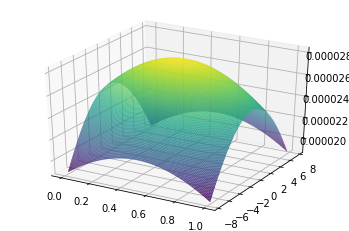

In [11]:
normal_1 = norm.pdf(Time, np.mean(Time), 1**(1/2)) # normal pdf
normal_2 = norm.pdf(State, np.mean(State), 100**(1/2))

Time_mu_0, State_mu_0 = np.meshgrid(normal_1[:, 0], normal_2[:, 0], indexing='ij') 

mu_tilde_0 = Time_mu_0 * State_mu_0
mu_tilde_0 = mu_tilde_0/np.sum(mu_tilde_0)

ax = plt.axes(projection='3d')
ax.plot_surface(Time_mesh_mu, State_mesh_mu, mu_tilde_0, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
plt.show()

Now we create the guess $\tilde m^{(0)}$: for each $t$ in the discretization of $[0, T[$, $\tilde m^{(0)}_t$ has to be a subprobability on the discretization of $\mathcal{O}$.

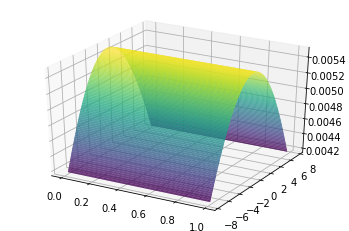

In [12]:
normal_3 = norm.pdf(State[1:-1, 0], np.mean(State[1:-1, 0]), 100**(1/2))
normal_3 = normal_3/np.sum(normal_3)

Time_m_0, State_m_0 = np.meshgrid(Time[:-1,0], normal_3, indexing='ij') 

m_tilde_0 = State_m_0 

ax = plt.axes(projection='3d')
ax.plot_surface(Time_mesh_m, State_mesh_m, m_tilde_0, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
plt.show()

Since in each iteration the mean field term will be fixed, we want to define the functions $b$, $\sigma$, $f$ and $g$ as functionals associating to each mean field term a function.

In [13]:
def b_factory(m, y):
    """
    Argument:
    m -- 2-array mean field term of size Time-State
    y -- Array. Auxiliary variable to compute the integrals with respect to m
    
    Returns:
    b -- drift associated to m
    """
    def b(t, x):
        """
        Argument:
        t -- Float. Time variable.
        x -- Float. State variable.
        
        Returns:
        b[m](t, x) -- Float.
        """
        i= np.where(Time[:-1, 0] == t)[0][0]
        m_t = m[i, :]
        return 1
    return np.vectorize(b)

def s_factory(m, y):
    """
    Argument:
    m -- 2-array mean field term of size Time-State
    y -- Array. Auxiliary variable to compute the integrals with respect to m
    
    Returns:
    s -- volatility associated to m
    """
    def s(t, x):
        """
        Argument:
        t -- Float. Time variable.
        x -- Float. State variable.
        
        Returns:
        s[m](t, x) -- Float.
        """
        i= np.where(Time[:-1, 0] == t)[0][0]
        m_t = m[i, :]
        return 1
    return np.vectorize(s)

def f_factory(m, y):
    """
    Argument:
    m -- 2-array mean field term of size Time-State
    y -- Array. Auxiliary variable to compute the integrals with respect to m
    
    Returns:
    f -- instantaneous reward associated to m
    """
    def f(t, x): 
        """
        Argument:
        t -- Float. Time variable.
        x -- Float. State variable.
        
        Returns:
        f[m](t, x) -- Float.
        """
        i= np.where(Time[:-1, 0] == t)[0][0]
        m_t = m[i, :]
        mean = np.sum((x-y)*m_t)
        return mean 
    return np.vectorize(f)

def g_factory(mu, s, y):
    """
    Argument:
    mu -- 2-array mean field term of size Time-State
    s, y -- Meshgrid. Auxiliary time variable to compute the integrals with respect to mu
    
    Returns:
    g -- final reward associated to mu
    """
    def g(t, x):
        """
        Argument:
        t -- Float. Time variable.
        x -- Float. State variable.
        
        Returns:
        g[mu](t, x) -- Float.
        """
        mean_t = np.sum((t-s)*mu)
        return mean_t
    return np.vectorize(g)

## 4) Results

We collect the results and visualize them on plots. 

In [14]:
%%time 

tol = 10**(-8)             # the iterations stop when error < tol
N_iter = 200                # the iterations stop when they reach N_iter
coeff_dep = False          # True if b or sigma depend on the measure, False otherwise
error = 'exploitability'   # Choose between 'exploitability' and 'dist'. When the coefficients b or sigma depend on the measure
                           # use 'dist'.

value, mu_bar, m_bar, mu_hat, m_hat, eps = fictitious_play(Time, State,
                                       b_factory, s_factory, Delta, delta, m0, f_factory, g_factory,
                                       tol, N_iter, mu_tilde_0, m_tilde_0, coeff_dep, error)

Set parameter TokenServer to value "PYGMALION"
Iteration:    1; Error:  0.068933
Iteration:    2; Error:  0.034803
Iteration:    3; Error:  0.023259
Iteration:    4; Error:  0.017456
Iteration:    5; Error:  0.013969
Iteration:    6; Error:  0.011643
Iteration:    7; Error:  0.009981
Iteration:    8; Error:  0.008734
Iteration:    9; Error:  0.007765
Iteration:   10; Error:  0.006989
Iteration:   11; Error:  0.006354
Iteration:   12; Error:  0.005824
Iteration:   13; Error:  0.005376
Iteration:   14; Error:  0.004992
Iteration:   15; Error:  0.004660
Iteration:   16; Error:  0.004368
Iteration:   17; Error:  0.004111
Iteration:   18; Error:  0.003883
Iteration:   19; Error:  0.003679
Iteration:   20; Error:  0.003495
Iteration:   21; Error:  0.003328
Iteration:   22; Error:  0.003177
Iteration:   23; Error:  0.003039
Iteration:   24; Error:  0.002912
Iteration:   25; Error:  0.002796
Iteration:   26; Error:  0.002688
Iteration:   27; Error:  0.002589
Iteration:   28; Error:  0.002496
I

In [15]:
np.save('mu_bar', mu_bar)
np.save('m_bar', m_bar)
np.save('eps', eps)

In [ ]:
mu_bar = np.load('mu_bar.npy')
m_bar = np.load('m_bar.npy')
eps = np.load('eps.npy')

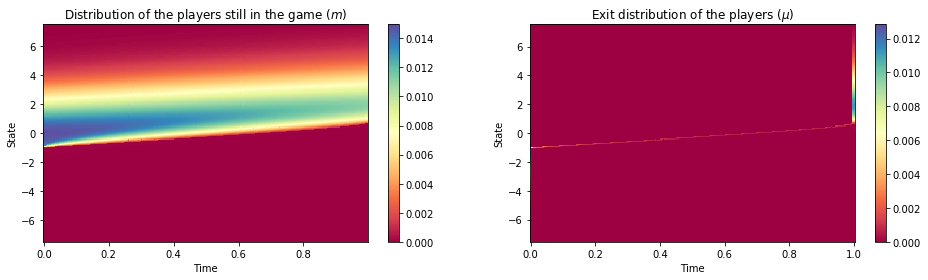

In [16]:
x_m, y_m = np.meshgrid(Time[:, 0]- Delta/2, State[1:, 0]- delta/2, indexing='ij') # Depends on the version of matplotlib
x_mu = np.append(Time[:, 0], Time[-1, 0]+Delta)- Delta/2
y_mu = np.append(State[:, 0], State[-1, 0]+delta)- delta/2
x_mu, y_mu = np.meshgrid(x_mu, y_mu, indexing='ij') 

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(1, 2, 1)  
ax2 = fig.add_subplot(1, 2, 2)

c1 = ax1.pcolormesh(x_m, y_m, m_bar, cmap='Spectral', vmin = m_bar.min(),
                          vmax = m_bar.max())

ax1.set_xlabel("Time")                     
ax1.set_ylabel("State")                     
ax1.set_title("Distribution of the players still in the game ($m$)")

fig.colorbar(c1, ax = ax1);

c2 = ax2.pcolormesh(x_mu, y_mu, mu_bar, cmap='Spectral',  vmin = mu_bar.min(),
                    vmax = mu_bar.max())

ax2.set_xlabel("Time")                     
ax2.set_ylabel("State")                     
ax2.set_title("Exit distribution of the players ($\mu$)")

fig.colorbar(c2, ax = ax2);

We can also compute the proportion of players still in the game for each time.

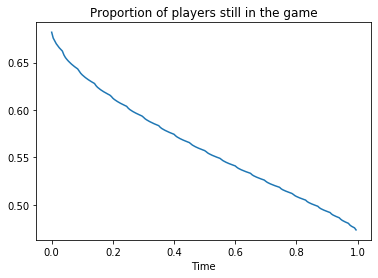

In [17]:
prop = np.sum(m_bar, axis=1)
plt.plot(Time[:-1, 0], prop)
plt.xlabel("Time")
plt.title("Proportion of players still in the game");

We can track the convergence of the algorithm via the exploitability.

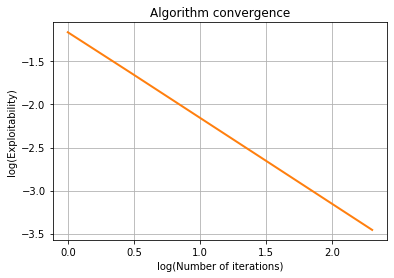

In [18]:
plt.plot(np.log10(np.arange(len(eps))+1), np.log10(eps), 'tab:orange', linewidth=2)
plt.title('Algorithm convergence')
plt.xlabel('log(Number of iterations)')
plt.ylabel('log(Exploitability)')
plt.grid();